In [903]:
import os 
import numpy as np
import scipy
from scipy import stats
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Anomaly Detection

In [904]:
data1 = io.loadmat("ex8data1.mat")
print(data1.keys())
X1 = data1["X"]
X1val = data1["Xval"]
Y1val = data1["yval"]

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


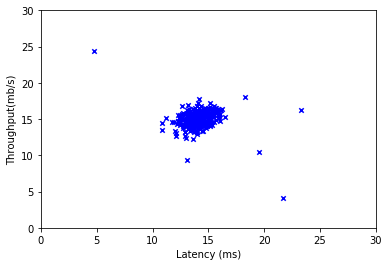

In [905]:
def plotData(x):
    plt.scatter(x[:,0], x[:,1], 20, marker="x", facecolor="b", edgecolors="b")
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.ylabel("Throughput(mb/s)")
    plt.xlabel("Latency (ms)")
#Plotting the data set
plotData(X1)

In [906]:
def estimateGaussian(x):
    m,n = x.shape
    mu =  np.mean(x, axis=0)
    sigma2 = np.var(x, axis=0)
    return mu, sigma2

In [907]:
mu, sigma2 = estimateGaussian(X1)

In [908]:
def multivariateGaussian(x,mu,sigma):
    m,n = x.shape
    k = mu.size
    z = np.square(x-mu)/(2*sigma)
    p = np.ones(m)
    for i in range(n):
        p1 = ((2*np.pi*sigma[i])**(-1/2))*np.exp(-z[:,i])
        p = p*p1
    return p

In [909]:
# p = multivariateGaussian(X1,mu,sigma2)

p = np.zeros((X1.shape[0], X1.shape[1]))  
p[:,0] = stats.norm(mu[0], sigma2[0]).pdf(X1[:,0])  
p[:,1] = stats.norm(mu[1], sigma2[1]).pdf(X1[:,1])

In [910]:
def visualizeFit(x,mu,sigma):
    x1,x2 = np.meshgrid(np.arange(0,35.5,.5), np.arange(0,35.5, 5))
    z = multivariateGaussian(np.stack([x1.ravel(), x2.ravel()],axis=1), mu, sigma)
    z = np.reshape(z, x1.shape)
    plotData(X1)
    if np.all(abs(z) != np.inf):
        plt.contour(x1, x2, z, levels=[10**exp for exp in range(-2,0,3)])

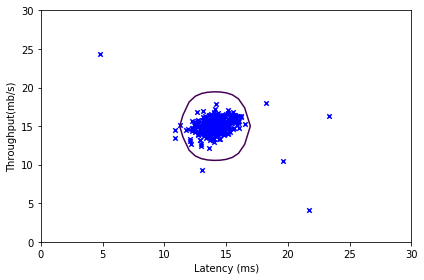

In [911]:
visualizeFit(X1,mu,sigma2)
plt.tight_layout()

In [912]:
def selectThreshold(yval, pval):
    bestE = 0
    bestF1 = 0
    F1 = 0
    for epsilon in np.linspace(min(pval.ravel()), max(pval.ravel()), 1000):
        pred = pval < epsilon
        tp = np.sum(np.logical_and(pred == 1, yval == 1)).astype(np.float)
        fp = np.sum(np.logical_and(pred == 1, yval== 0)).astype(np.float)
        fn = np.sum(np.logical_and(pred == 0, yval == 1)).astype(np.float)
        tn = np.sum(np.logical_and(pred == 0, yval == 0)).astype(np.float)
        pre = tp/(tp+fp)
        rec = tp/(tp+fn)
        F1 = 2*pre*rec/(pre+rec)
        if F1>bestF1:
            bestF1 = F1
            bestE = epsilon
    return bestE, bestF1

In [913]:
# pval = multivariateGaussian(X1val, mu, sigma2)
pval = np.zeros((X1val.shape[0], X1val.shape[1]))  
pval[:,0] = stats.norm(mu[0], sigma2[0]).pdf(X1val[:,0])  
pval[:,1] = stats.norm(mu[1], sigma2[1]).pdf(X1val[:,1])
pval = pval[:,0]*pval[:,1]

E, F_score = selectThreshold(Y1val, pval)
E, F_score

(0.050793045434594314, 0.056956724057701254)

In [914]:
outliers = np.where(p < E)

In [915]:
outliers

(array([147, 170, 300, 301, 301, 303, 303, 304, 305, 306, 306]),
 array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]))

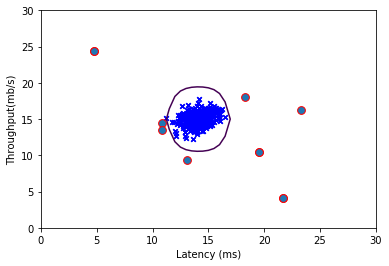

In [916]:
plotData(X1)
visualizeFit(X1,mu,sigma2)
plt.scatter(X1[outliers[0],0], X1[outliers[0],1], 60, marker="o", edgecolors="r")

In [917]:
data2 = io.loadmat("ex8data2.mat")
print(data2.keys())
X2 = data2["X"]
X2val = data2["Xval"]
Y2val = data2["yval"]

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


In [686]:
mu2, sig2 = estimateGaussian(X2)
p2 = multivariateGaussian(X2, mu2, sig2)
p2val = multivariateGaussian(X2val, mu2, sig2)

In [687]:
E2, F2  = selectThreshold(Y2val, p2val)
E2, F2

(7.113614384114647e-16, 0.18165137614678897)

In [688]:
outliers2 = np.where(p2 < 1.38e-18)
np.count_nonzero(outliers2)

118

## Recommender System

In [802]:
data3 = io.loadmat("ex8_movies.mat")
print(data3.keys())
Y, R = data3["Y"], data3["R"]

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])


Text(0.5,0,'Users')

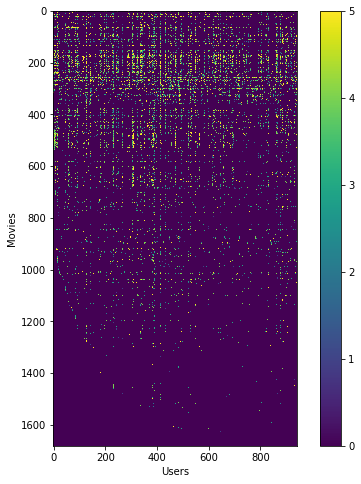

In [803]:
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies')
plt.xlabel('Users')

In [804]:
data3_params = io.loadmat("ex8_movieParams.mat")
print(data3_params.keys())
X = data3_params["X"]
theta = data3_params["Theta"]
nu, nm, nf = data3_params["num_users"], data3_params["num_movies"], data3_params["num_features"]

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])


In [877]:
#params = flatterned arrays of X and theta as J is minimizing both X and theta
def cofiCostFunc(params, y, r , num_users, num_movies, num_features, reg):
    x = np.reshape(params[:num_movies*num_features], (num_movies,num_features))
    theta = np.reshape(params[num_movies*num_features:], (num_users, num_features))
    J = 0
    x_grad = np.zeros(X.shape)
    theta_grad = np.zeros(theta.shape)
    
    J =  0.5*((np.sum(np.square(np.multiply(x.dot(theta.T),r)-y)))+ reg*(np.sum(np.square(theta)) + np.sum(np.square(x))))
    
    x_grad = (np.multiply(x.dot(theta.T),r)-y).dot(theta) + reg*x
    theta_grad  = (np.multiply(x.dot(theta.T),r)-y).T.dot(x) + reg*theta
    
    grad = np.concatenate([x_grad.ravel(), theta_grad.ravel()])
    return J, grad

In [878]:
#Reduced size data
num_users = 4; num_movies = 5; num_features = 3
X_red = X[0:num_movies,0:num_features]
theta_red = theta[0:num_users, 0:num_features]
Y_red = Y[0:num_movies, 0:num_users]
R_red = R[0:num_movies, 0:num_users]
#parameters using x and theta
params = np.concatenate([X_red.ravel(), theta_red.ravel()])
J, grad= cofiCostFunc(params, Y_red, R_red , num_users, num_movies, num_features, reg=0)